# Photometry

In order to measure Petrosian properties of galaxies, we must fist measure the photometry to construct a curve of growth. We use a set of concentric apertures with varying radii to measure the flux and construct the curve of growth. To achieve an accurate measurement, we must first identify sources in an image, mask neighboring galaxies and correct for background noise.

## Loading Example Data

The following data is a cutout of a bright galaxy in Abell-2744. The original data was aquired by the [Hubble Frontier Fields](https://frontierfields.org) team via the WFC3 instrument (`F105W` filter) and can be dirctly downloaded [here](https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0/hlsp_frontier_hst_wfc3-60mas_abell2744_f105w_v1.0_drz.fits). 

We first use `astropy`'s ``CCDData`` to load the example data and visualize it through `matplotlib`.

In [1]:
from astropy.nddata import CCDData

image = CCDData.read('data/abell_2744_cd_galaxy_f105w.fits.gz')

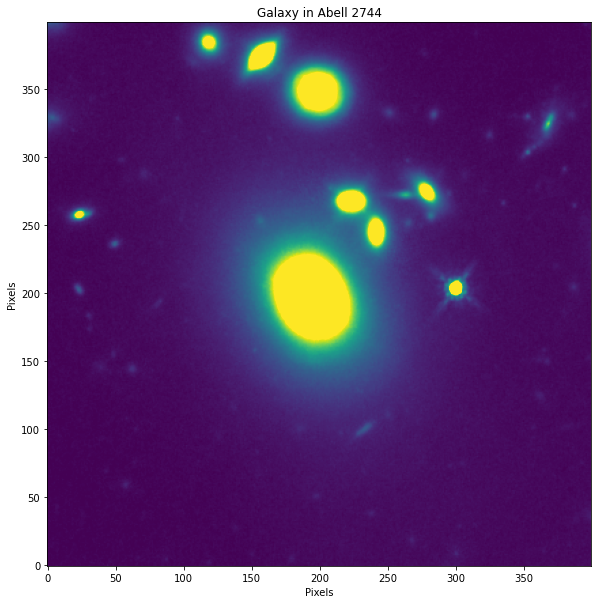

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'

vmax = image.data.std() # Use the image std as max and min of all plots 
vmin = - vmax 

plt.imshow(image.data, vmin=0, vmax=image.data.std())
plt.title("Galaxy in Abell 2744")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

### Estimate data noise at dark area

0.0043369904 0.003988121054135263 0.010634989477694035


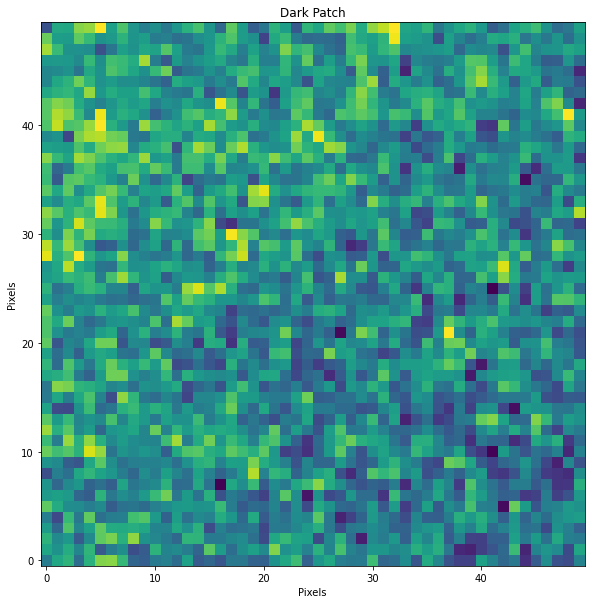

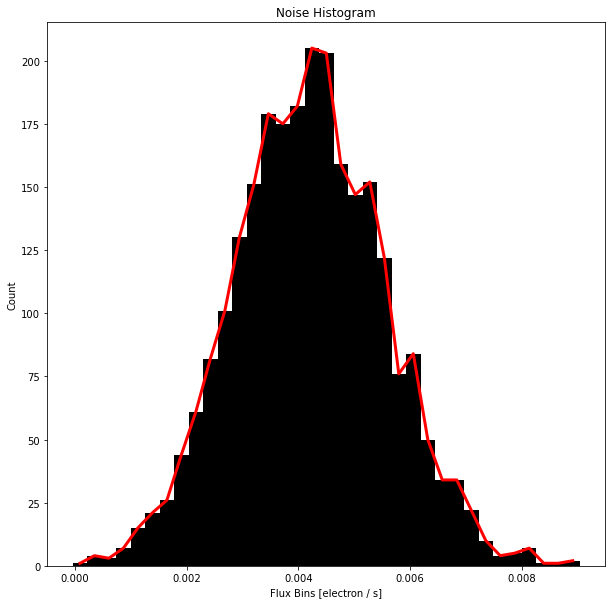

In [3]:
from astropy.nddata import Cutout2D

# Estimate data noise at dark area
# --------------------------------
noise_cutout = Cutout2D(image, (350, 50), 50)

noise_mean = noise_cutout.data.mean()
noise_sigma = noise_cutout.data.std()
noise_3_sigma = noise_sigma * 3.
noise_8_sigma = noise_sigma * 8.

print(noise_mean, noise_3_sigma, noise_8_sigma)

# Plot image and noise distribution
# ---------------------------------
plt.imshow(noise_cutout.data, vmax=noise_mean+noise_3_sigma, vmin=noise_mean-noise_3_sigma)
plt.title("Dark Patch")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

n, bins, patches = plt.hist(noise_cutout.data.flatten(), bins=35, align='left', color='black')
plt.plot(bins[:-1], n, c='r', linewidth=3)

plt.xlabel('Flux Bins [{}]'.format(str(image.unit)))
plt.ylabel('Count')
plt.title('Noise Histogram')
plt.show()

## Segmentation and Deblending

Now that we have the image loaded, we need to identfiy the sources in the image. To do this, we use `photutils` and the wrappers in `petrofit`. We first start by defining the detection threshold and making a 2D array (the same size as the image), with all values set to the threshold. We select this value to be the data standard dev or `image_std` computed in the last section.

In [4]:
import numpy as np

# Define detect threshold
nsigma = np.ones_like(image.data)
nsigma[:, :] = noise_8_sigma

Next, we define the parameters of a Gaussian kernel that is used to smooth the image before segmentation. The `kernel_size` defines the dimensions of the smoothing kernel and `fwhm` which is used to compute the `sigma` value of the Gaussian distribution. The `fwhm` is used to compute the `sigma` value as follows: 

```
sigma = fwhm * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=kernel_size, y_size=kernel_size)
```

In [5]:
# Define smoothing kernel
kernel_size = 3
fwhm = 3

We also have to define the number of pixels that make up the smallest object. `npixels` is the number of connected pixels, each greater than threshold value, that an object must have to be detected. `npixels` must be a positive integer.

In [6]:
npixels = 4**2

Now we can make the segmentation map of the image using a `photutils` wrapper function and store the results in `segm`. We also use the `plot_segments` function to plot the segmentation map over the image.

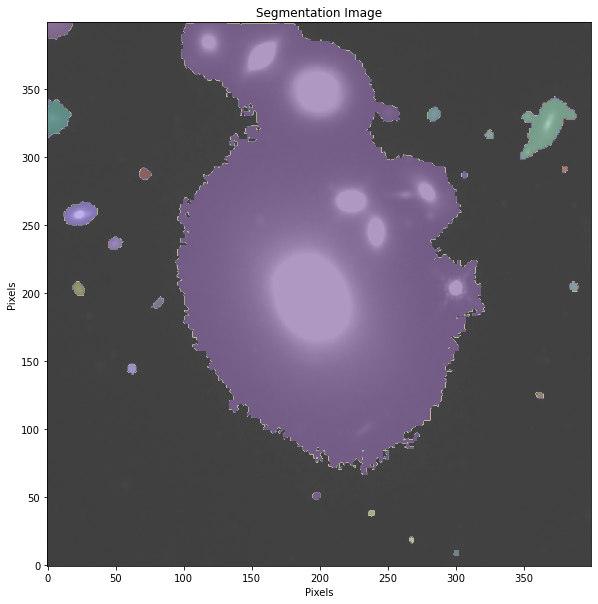

In [7]:
from petrofit.segmentation import make_segments, plot_segments

# Make segmentation map
segm = make_segments(image.data, nsigma=nsigma, 
                     kernel_size=kernel_size, 
                     fwhm=fwhm, npixels=npixels)

# Make plots 
plot_segments(segm, image=image.data, vmax=vmax, vmin=vmin)
plt.show()

As you can see, the segmentation resulted in the identification sources but the sources at the center  were classified as a single object because they have interconnecting pixels that are above the threshold. To further distinguish the sources, we use `photutils` to deblend the sources into individual galaxies. The `contrast` parameter is the fraction of the total (blended) source flux that a local peak must have (at any one of the multi-thresholds) to be considered as a separate object and `nlevels` is the number of multi-thresholding levels to use. We again use a wrapper for `photutils` to do this: 

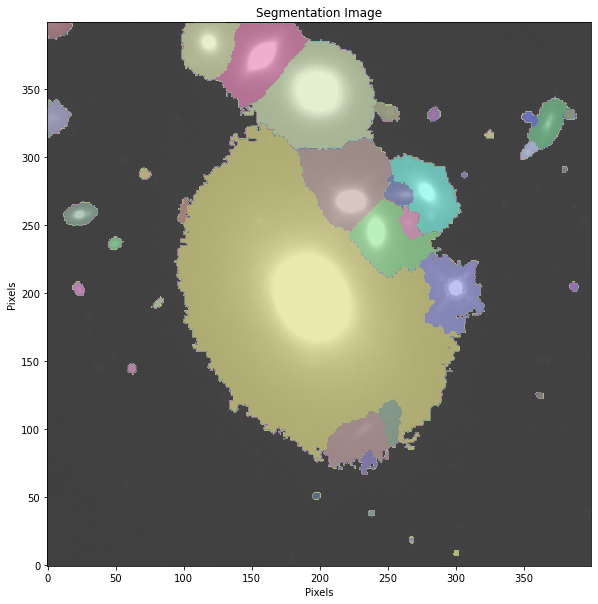

In [8]:
from petrofit.segmentation import deblend_segments

# Deblend segmentation map
segm_deblend = deblend_segments(image.data, segm, contrast=0, nlevels=50,
                                kernel_size=kernel_size, 
                                fwhm=fwhm, npixels=npixels)
# Make plots 
plot_segments(segm_deblend, image=image.data, vmax=vmax, vmin=vmin)
plt.show()

into individual sources. The next step is to create a source catalog that contains properties like `(xcentroid, ycentroid)`, `eccentricity` and `area`. To demonstrate the useful information in the catalog, we convert the `SourceCatalog` to an `astropy.table.Table` and display the first 10 objects.

In [9]:
from photutils.segmentation import SourceCatalog 
#segm_deblend.remove_border_labels(1)

# Make catalog
cat = SourceCatalog(image.data, segm_deblend, wcs=image.wcs)

# Display source properties
print("Num of Targets:", len(cat))

# Convert to table
cat_table = cat.to_table()

cat_table[:10]

Num of Targets: 37


label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,"deg,deg",,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float32,float32,float64,float32,float64,float64,float64
1,300.3111014747076,8.957733205325145,"3.592749151675601,-30.394775318468113",298,302,7,11,22.0,1.3002066884255192,1.1954394910185,72.92896928748888,0.3932708655592488,0.009680937,0.020702347,0.0,0.3065427,nan,2.9920230859962698,nan
2,267.6609266662787,18.696772251857766,"3.5933800122438053,-30.394612959804533",266,269,16,21,18.0,1.338815823770431,0.9435980860927524,-78.1182121287477,0.7094055468027852,0.009548313,0.017403107,0.0,0.23814538,nan,2.2383246514730155,nan
3,238.08409785892172,38.30342199684979,"3.5939514687306926,-30.394286142171232",236,240,36,40,20.0,1.3160830369300207,1.097083917391687,21.735263634130096,0.5523719005005615,0.009238662,0.017663734,0.0,0.2633968,nan,2.6618375664393312,nan
4,197.5697198251521,51.062209393988894,"3.5947342719268875,-30.394073436784915",195,200,49,53,27.0,1.5342966800421625,1.2525893291540873,11.576258577481264,0.5774964876425596,0.0096896775,0.019357374,0.0,0.36633033,nan,4.036844715725884,nan
5,361.8704549222154,125.04174876834449,"3.5915595175034873,-30.392840653733412",359,364,123,127,24.0,1.5118081589389682,1.188072778867685,-34.625486180578605,0.6184017413798576,0.010862355,0.016101524,0.0,0.3197428,nan,2.662793396605057,nan
6,62.10086910986217,144.57752341458848,"3.5973516018950575,-30.39251461697542",59,65,141,148,43.0,1.748703072684326,1.645928883735497,-78.53671298174064,0.33777095641812893,0.009224219,0.025306074,0.0,0.6967492,nan,3.3119208425650255,nan
7,81.3936123710383,192.77146336446825,"3.5969787171133256,-30.39171142038371",77,85,189,197,42.0,2.5685002130935906,1.174078120992925,46.5552660419501,0.8894119716804528,0.009319109,0.023461932,0.0,0.5970321,nan,6.024382598248996,nan
8,22.901215834212646,203.17552689837655,"3.5981088645357167,-30.3915379067499",19,27,199,208,67.0,2.3729264639989727,1.63305574155445,-57.741529381540104,0.7255179289421537,0.010086361,0.055048924,0.0,1.6724185,nan,3.278041064316148,nan


## Photometry on Single Source

In [10]:
from petrofit.photometry import order_cat, source_photometry, make_radius_list

In [54]:
max_pix = 150
n = 50
r_list = make_radius_list(max_pix=max_pix, n=n)

22


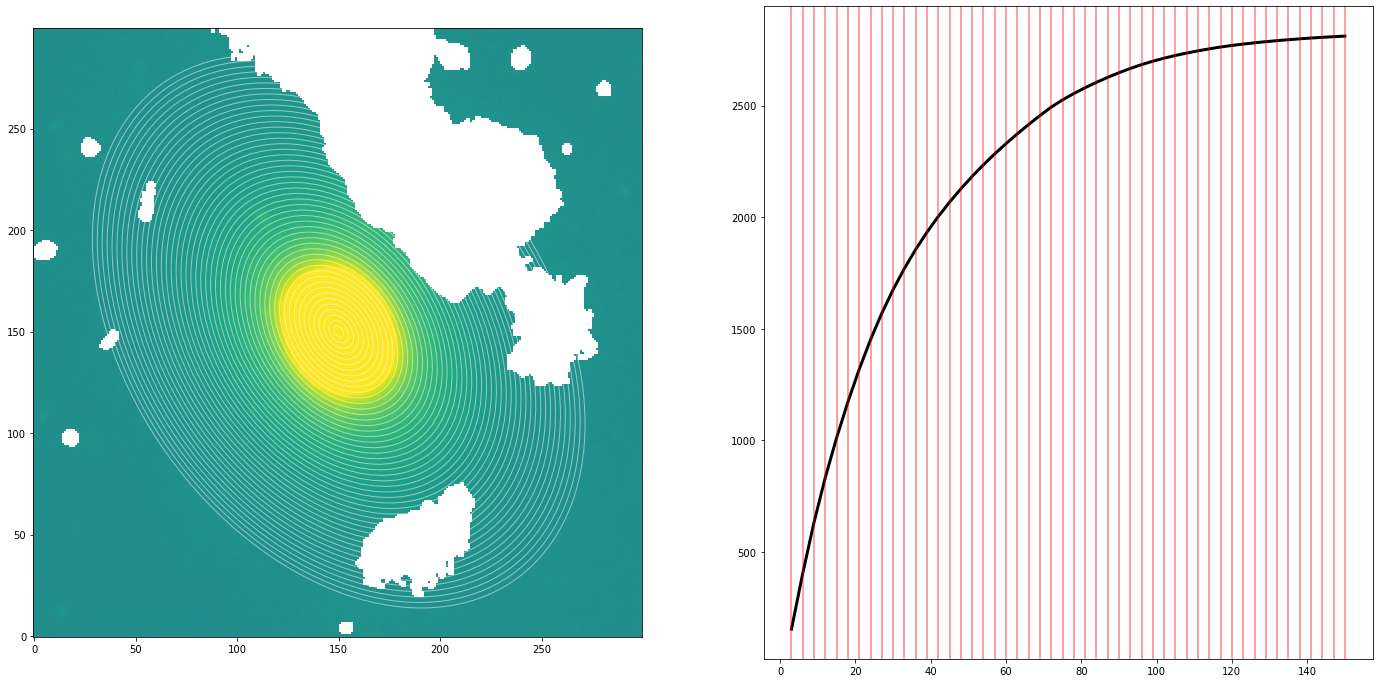

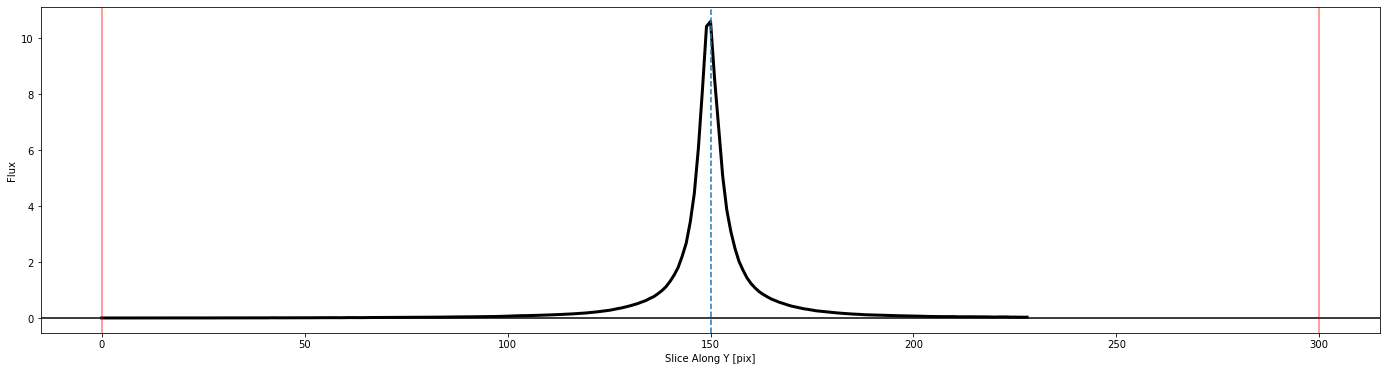

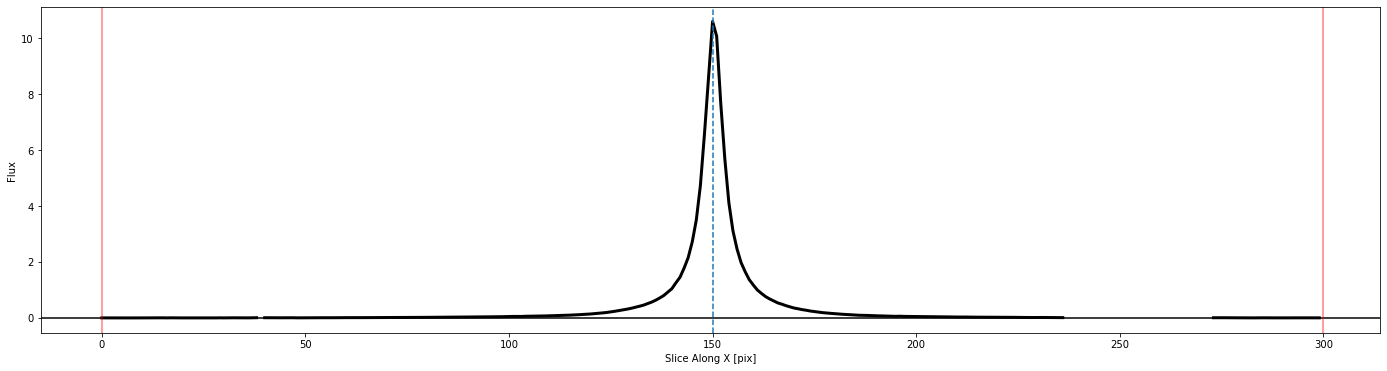

In [55]:
# Sort and get the largest object in the catalog
idx = order_cat(cat)[0]  # index 0 is largest 
obj = cat[idx]  # get object (source) from the catalog 

# Photomerty 
flux_arr, area_arr, error_arr = source_photometry(
    obj, image.data, segm_deblend, r_list, 
    bkg_sub=True, sigma=1, sigma_type='clip',
    plot=True, vmax=vmax, vmin=vmin, 
    mask_background=False,
    cutout_size=max_pix*2, 
)
plt.show()

# Petrosian

## Petrosian Radii

### Construct Petrosian from Photometry

In [40]:
from petrofit.petrosian import Petrosian
p = Petrosian(r_list, area_arr, flux_arr)

### Petrosian radius

In [41]:
p.r_petrosian # in pixels

64.00240048009601

### Petrosian total flux radius

In [42]:
p.r_total_flux # pixels

128.00480096019203

In [43]:
p.r_total_flux_arcsec(image.wcs) # arcsec

7.680286633733112

### Petrosian half light radius

In [44]:
p.r_half_light # pixels

22.60852170434087

In [45]:
p.r_half_light_arcsec(image.wcs) # arcsec

1.3565110507715572

### Concentration Index

In [46]:
r_20, r_80, c2080 = p.concentration_index()  # defualt c2080

r_20, r_80, c2080

(7.946389277855571, 53.5747149429886, 4.143950162434329)

In [47]:
r_50, r_90, c5090 = p.concentration_index(fraction_1=0.5, fraction_2=0.9)  # defualt c2080

r_50, r_90, c5090

(22.60852170434087, 73.1626325265053, 2.5500857879648975)

### Plot

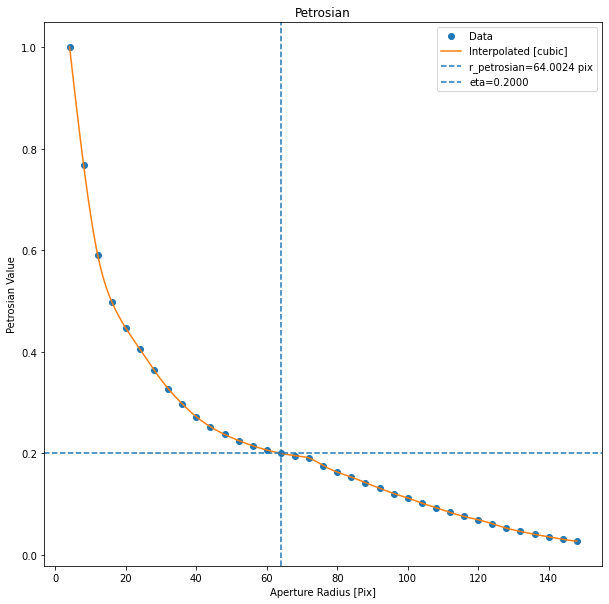

In [48]:
p.plot()

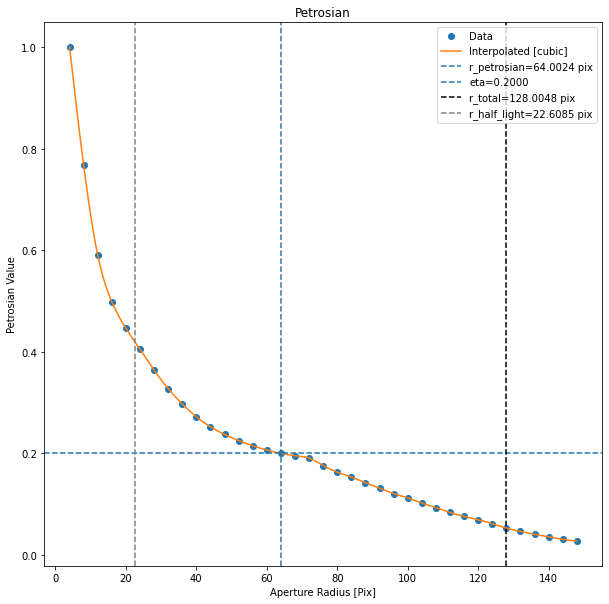

In [49]:
# Plot with radii 
p.plot(plot_r=True)

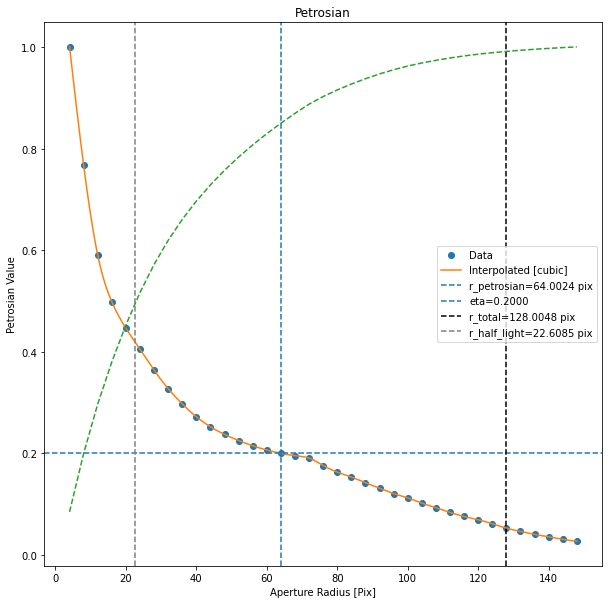

In [50]:
# Plot with radii and overplot normalized flux curve of growth
p.plot(plot_r=True, plot_normalized_flux=True)

### Change eta and epsilon

epsilon : float

    Epsilon value (used to determine `r_total_flux`).

    N.B: `r_total_flux` = `r_petrosian` * `epsilon`

eta : float, default=0.2

    Eta is the petrosian value which defines the `r_petrosian`.

eta = 0.2
epsilon = 2.0
r_half_light = 23.251050210042006
r_total_flux = 136.36647329465893


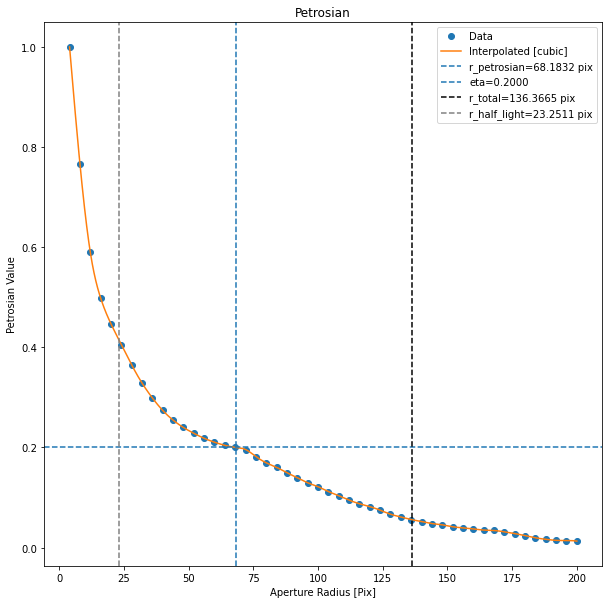

In [24]:
print('eta =', p.eta)
print('epsilon =', p.epsilon)
print('r_half_light =', p.r_half_light)
print('r_total_flux =', p.r_total_flux)

p.plot(plot_r=True)

eta = 0.3
epsilon = 3
r_half_light = 22.349269853970792
r_total_flux = 107.39267853570713


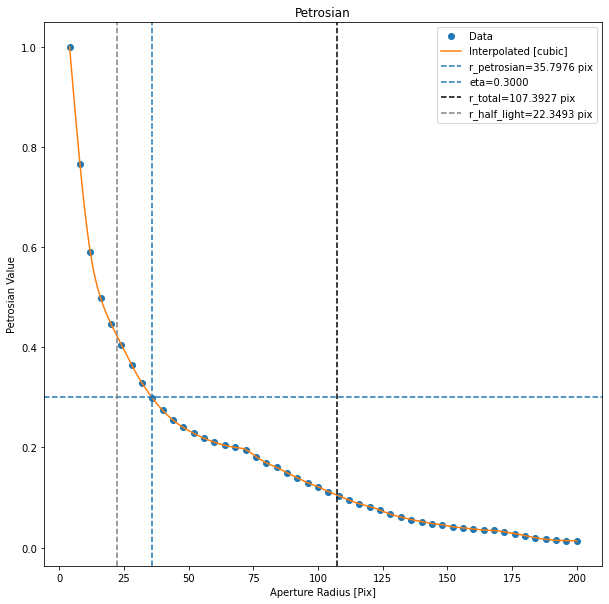

In [25]:
from copy import copy

p_copy = copy(p)
p_copy.eta = 0.3
p_copy.epsilon = 3

print('eta =', p_copy.eta)
print('epsilon =', p_copy.epsilon)
print('r_half_light =', p_copy.r_half_light)
print('r_total_flux =', p_copy.r_total_flux)

p_copy.plot(plot_r=True)